In [1]:
import os
import sys
sys.path.append(os.getcwd() + '/codes')

In [2]:
import copy

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pricing_model import get_gamma
from agent import MVPITD3Agent
from utils import Config, MeanStdNormalizer
from Envs import DeltaHedgingEnv, DeltaHedgingEnvTiming
from component import Task
from component.replay import *
from component.random_process import *
from network import GaussianActorCriticNet, FCBody, TwoLayerFCBodyWithAction, ThreeLayerFCBodyWithAction, TD3Net, RTD3Net, OneDenseLSTM

In [3]:
os.listdir(os.getcwd()+'/codes/log')

['DeltaHedgingTiming-v0-asset_model_GBM-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-220104-071202.txt',
 'DeltaHedgingTiming-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-220102-232124.txt',
 'DeltaHedgingTiming-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-220103-030352.txt',
 'DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-220109-221009.txt',
 'DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-220110-010132.txt',
 'DeltaHedgingTiming-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-220103-031245.txt',
 'DeltaHedgingTiming-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-220102-234110.txt',
 'DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-

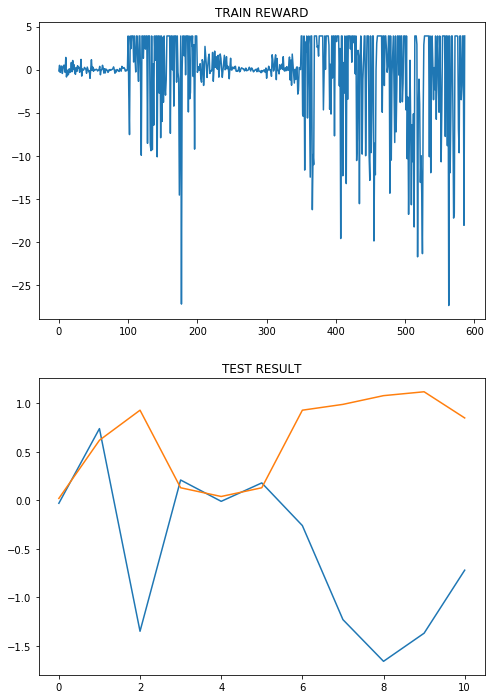

In [12]:
file = 'DeltaHedgingTiming-v0-asset_model_GBM-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-220102-225950.txt'
dir_name = os.getcwd()
with open(dir_name + '/codes/log/' + file) as f:
    log_str = f.readlines()
    train_log = list(filter(lambda x: 'train' in x, log_str))
    test_log = list(filter(lambda x: 'test' in x, log_str))
return_train =  list(map(lambda x: float(x.split(' ')[-1]), train_log))
return_test = list(map(lambda x: float(x.split(' ')[-1].split('(')[0]), test_log))
std_test = list(map(lambda x: float(x.split(' ')[-1].split('(')[1][:-2]), test_log))

fig = plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
plt.plot(return_train)
plt.title('TRAIN REWARD')
plt.subplot(2,1,2)
plt.plot(return_test)
plt.plot(std_test)
plt.title('TEST RESULT');

In [4]:
config_dict = {'data_type':'simulation',
               'hedging_task':'DeltaHedging-v0',
               'asset_model':'GBM',
               'strike_price':100,
               'option_type':'C',
               'lam':0.5}
# sorted(os.listdir(dir_name + '/code/model/'))

In [5]:
config = Config()
config.tag = None

In [6]:
config_dict.setdefault('log_level', 0)
config_dict.setdefault('action_noise', 0)
config.merge(config_dict)

config.task_fn = lambda: Task(config.hedging_task, action_noise=config.action_noise, config=config)
config.eval_env = config.task_fn()
config.eval_interval = int(5e4)
config.eval_episodes = 1000

config.network_fn = lambda: TD3Net(
    config.action_dim,
    actor_body_fn=lambda: FCBody(config.state_dim, (400, 300), gate=F.relu),
    critic_body_fn=lambda: FCBody(
        config.state_dim+config.action_dim, (400, 300), gate=F.relu),
    actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
    critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

config.discount = 0.99
config.td3_delay = 2
config.warm_up = int(1e4)
config.target_network_mix = 5e-3
config.replay_fn = lambda: Replay(memory_size=int(5e4), batch_size=100)
config.random_process_fn = lambda: GaussianProcess(
    size=(config.action_dim,), std=LinearSchedule(0.1))
config.td3_noise = 0.2
config.td3_noise_clip = 0.5
config.td3_delay = 2

In [7]:
deltahedging_env = DeltaHedgingEnv(config)

In [8]:
td3_agent = MVPITD3Agent(config)

In [423]:
dir_name = os.getcwd()
model_index = 61


step_num = 9000 * model_index
filename = dir_name + '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-'+ f'{step_num}' + '.model'

state_dict = torch.load(filename)
td3_agent.network.load_state_dict(state_dict)

<All keys matched successfully>

In [424]:
state_list = []
action_array = np.array([])
action_mean_array = np.array([])
delta_array = np.array([])
reward_array = np.array([])
delta_pnl_array = np.array([])



done = False
state = deltahedging_env.reset()
while not done:
    action = td3_agent.eval_step(state)
    action_mean = td3_agent.eval_step(state)
    delta = deltahedging_env.env_params.delta.copy()
    next_state, hedging_performance, done, _ = deltahedging_env.step(action, delta_check=True)
    if not done:
        state_list.append(state.reshape(1,-1))
        action_array = np.append(action_array, action)
        action_mean_array = np.append(action_mean_array, action_mean)
        reward_array = np.append(reward_array, hedging_performance[0])
        delta_pnl_array = np.append(delta_pnl_array, hedging_performance[1])
        delta_array = np.append(delta_array, delta)
        state = next_state
        
        
state_array = np.concatenate(state_list)

-0.04004986704016125 0.013894029155477437


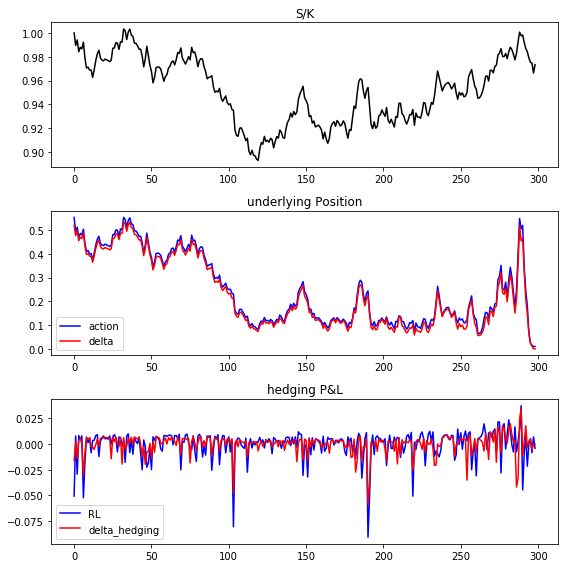

In [437]:
fig = plt.figure(figsize=(8,8))

plt.subplot(3,1,1)
plt.plot(state_array[:,0], color='k')
plt.title('S/K')
plt.subplot(3,1,2)
plt.plot(action_array, label='action', color='b')
plt.plot(delta_array, label='delta', color='r')
plt.title('underlying Position')
plt.legend()
plt.subplot(3,1,3)
plt.plot(reward_array, label='RL', color='b')
plt.plot(delta_pnl_array, label='delta_hedging', color='r')
plt.title('hedging P&L')
plt.legend()

print(reward_array.sum(), reward_array.std())

plt.tight_layout()

# test

In [3]:
config = Config()
config.DEVICE = torch.device('cuda:1')
config.tag = None

In [48]:
base_gbm_model_list = [
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-'
]

base_heston_model_list = [
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-'
]
lstm_gbm_model_list = [
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-burnin_len_5-data_type_simulation-history_len_10-lam_0.5-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-burnin_len_5-data_type_simulation-history_len_10-lam_0.75-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-burnin_len_5-data_type_simulation-history_len_10-lam_1.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-burnin_len_5-data_type_simulation-history_len_10-lam_2.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-burnin_len_5-data_type_simulation-history_len_10-lam_5.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_GBM-burnin_len_5-data_type_simulation-history_len_10-lam_10.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
]

lstm_heston_model_list = [
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_0.5-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_0.75-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_1.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_2.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_5.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
    '/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_10.0-nn_model_lstm-option_type_C-strike_price_100.0-run-0-',
]

In [106]:
config_dict = {'data_type':'simulation',
               'hedging_task':'DeltaHedging-v0',
               'asset_model':'Heston',
               'strike_price':100,
               'option_type':'C',
               'lam':0.5,
               'nn_model':'dnn',
               'history_len':10,
               'burnin_len':5}

In [76]:
config_dict.setdefault('log_level', 0)
config_dict.setdefault('action_noise', 0)
config.merge(config_dict)

config.task_fn = lambda: Task(config.hedging_task, action_noise=config.action_noise, config=config)
config.eval_env = config.task_fn()
config.eval_interval = int(5e4)
config.eval_episodes = 1000

config.network_fn = lambda: TD3Net(
    config.action_dim,
    actor_body_fn=lambda: FCBody(config.state_dim, (400, 300), gate=F.relu),
    critic_body_fn=lambda: FCBody(
        config.state_dim+config.action_dim, (400, 300), gate=F.relu),
    actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
    critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

config.discount = 0.99
config.td3_delay = 2
config.warm_up = int(1e4)
config.target_network_mix = 5e-3
config.replay_fn = lambda: Replay(memory_size=int(5e4), batch_size=100)
config.random_process_fn = lambda: GaussianProcess(
    size=(config.action_dim,), std=LinearSchedule(0.1))
config.td3_noise = 0.2
config.td3_noise_clip = 0.5
config.td3_delay = 2

In [79]:
reward_list = []
total_sum_array = np.zeros(0)
total_mean_array = np.zeros(0)
total_std_array = np.zeros(0)
for model_name in base_heston_model_list:
    td3_agent = MVPITD3Agent(config)
    dir_name = os.getcwd()

    for model_index in range(1, 200000//9000 + 1):
        step_num = 9000 * model_index
        filename = dir_name + model_name + f'{step_num}' + '.model'

        state_dict = torch.load(filename)
        td3_agent.network.load_state_dict(state_dict)

        state_list = []
        action_array = np.array([])
        action_mean_array = np.array([])
        delta_array = np.array([])
        reward_array = np.array([])
        delta_pnl_array = np.array([])
        
        deltahedging_env = DeltaHedgingEnv(config, seed=0)
        
        for i in tqdm(range(200)):

            done = False
            state = deltahedging_env.reset()
            while not done:
                action = td3_agent.eval_step(state)
                delta = deltahedging_env.env_params.delta.copy()
                next_state, hedging_performance, done, _ = deltahedging_env.step(action, delta_check=True)
                if not done:
                    state_list.append(state.reshape(1,-1))
                    action_array = np.append(action_array, action)
                    reward_array = np.append(reward_array, hedging_performance[0])
                    delta_pnl_array = np.append(delta_pnl_array, hedging_performance[1])
                    delta_array = np.append(delta_array, delta)
                    state = next_state

            
            reward_list.append([reward_array.sum(), reward_array.mean(), reward_array.std()])
        print(str(model_name) + '\n' + str(model_index))
            
        total_sum_array = np.append(total_sum_array, np.array(reward_list)[:,0].mean())
        total_mean_array = np.append(total_mean_array, np.array(reward_list)[:,1].mean())
        total_std_array = np.append(total_std_array, np.array(reward_list)[:,2].mean())

  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
1


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
2


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
3


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
4


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
5


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
6


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
7


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
8


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
9


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
10


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
11


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
12


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
13


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
14


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
15


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
16


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
17


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
18


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
19


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
20


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
21


100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.5-option_type_C-strike_price_100.0-run-0-
22


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
1


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
2


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
3


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
4


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
5


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
6


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
7


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
8


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
9


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
10


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
11


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
12


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
13


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
14


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
15


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
16


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
17


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
18


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
19


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
20


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
21


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_0.75-option_type_C-strike_price_100.0-run-0-
22


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
1


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
2


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
3


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
4


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
5


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
6


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
7


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
8


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
9


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
10


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
11


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
12


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
13


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
14


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
15


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
16


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
17


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
18


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
19


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
20


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
21


100%|██████████| 200/200 [01:04<00:00,  3.11it/s]


/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_1.0-option_type_C-strike_price_100.0-run-0-
22


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
1


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
2


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
3


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
4


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
5


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
6


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
7


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
8


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
9


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
10


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
11


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
12


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
13


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
14


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
15


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
16


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
17


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
18


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
19


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
20


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
21


100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_2.0-option_type_C-strike_price_100.0-run-0-
22


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
1


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
2


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
3


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
4


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
5


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
6


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
7


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
8


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
9


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
10


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
11


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
12


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
13


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
14


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
15


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
16


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
17


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
18


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
19


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
20


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
21


100%|██████████| 200/200 [01:04<00:00,  3.08it/s]


/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_5.0-option_type_C-strike_price_100.0-run-0-
22


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
1


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
2


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
3


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
4


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
5


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
6


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
7


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
8


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
9


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
10


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
11


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
12


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
13


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
14


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
15


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
16


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
17


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
18


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
19


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
20


  0%|          | 0/200 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
21


100%|██████████| 200/200 [01:04<00:00,  3.11it/s]

/codes/model/MVPITD3Agent-DeltaHedging-v0-asset_model_Heston-data_type_simulation-lam_10.0-option_type_C-strike_price_100.0-run-0-
22


In [212]:
config_dict = {'data_type':'simulation',
               'hedging_task':'DeltaHedging-v0',
               'asset_model':'Heston',
               'strike_price':100,
               'option_type':'C',
               'lam':0.5,
               'nn_model':'lstm',
               'history_len':10,
               'burnin_len':5}

In [213]:
config_dict.setdefault('log_level', 0)
config_dict.setdefault('action_noise', 0)
config.merge(config_dict)

config.task_fn = lambda: Task(config.hedging_task, action_noise=config.action_noise, config=config)
config.eval_env = config.task_fn()
config.eval_interval = int(5e4)
config.eval_episodes = 1000
config.lstm_encoding_size = 4
config.hidden_size = 32
config.actor_encoding_size = 3
config.critic_encoding_size = 4

config.network_fn = lambda: RTD3Net(
    config.state_dim,
    config.action_dim,
    config.actor_encoding_size,
    config.critic_encoding_size,
    actor_body_fn=lambda: OneDenseLSTM(config.state_dim+config.action_dim, config.lstm_encoding_size,
                                   config.hidden_size, config=config, gate=F.relu),
    critic_body_fn=lambda: OneDenseLSTM(
        config.state_dim+config.action_dim, config.lstm_encoding_size, config.hidden_size,
        config=config, gate=F.relu),
    actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
    critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))


config.discount = 0.99
config.td3_delay = 2
config.warm_up = int(1e4)
config.target_network_mix = 5e-3
config.replay_fn = lambda: Replay(memory_size=int(5e4), batch_size=100)
config.random_process_fn = lambda: GaussianProcess(
    size=(config.action_dim,), std=LinearSchedule(0.1))
config.td3_noise = 0.2
config.td3_noise_clip = 0.5
config.td3_delay = 2

In [49]:
reward_list = []
total_sum_array = np.zeros(0)
total_mean_array = np.zeros(0)
total_std_array = np.zeros(0)
total_delta_pnl_array = np.zeros(0)
for model_name in lstm_heston_model_list:
    td3_agent = MVPITD3Agent(config)
    dir_name = os.getcwd()

    for model_index in range(1, 350000//9000 + 1):
        step_num = 9000 * model_index
        filename = dir_name + model_name + f'{step_num}' + '.model'

        state_dict = torch.load(filename)
        td3_agent.network.load_state_dict(state_dict)

        state_list = []
        action_array = np.array([])
        action_mean_array = np.array([])
        delta_array = np.array([])
        reward_array = np.array([])
        delta_pnl_array = np.array([])
        
        deltahedging_env = DeltaHedgingEnv(config, seed=0)
        
        for i in tqdm(range(100)):

            done = False
            state = deltahedging_env.reset()
            while not done:
                state = state.reshape(1,-1)
                action = td3_agent.eval_step(state, history=td3_agent.history)
                td3_agent.history.append(np.hstack([state, action]).flatten())
                delta = deltahedging_env.env_params.delta.copy()
                next_state, hedging_performance, done, _ = deltahedging_env.step(action, delta_check=True)
                if not done:
                    state_list.append(state)
                    action_array = np.append(action_array, action)
                    reward_array = np.append(reward_array, hedging_performance[0])
                    delta_pnl_array = np.append(delta_pnl_array, hedging_performance[1])
                    delta_array = np.append(delta_array, delta)
                    state = next_state
                    
            td3_agent.history_reset(config)         
            reward_list.append([reward_array.sum(), reward_array.mean(), reward_array.std()])
            
        print(str(model_name) + '\n' + str(model_index))
        
        total_delta_pnl_array = np.append(total_delta_pnl_array, delta_pnl_array)
        
        total_sum_array = np.append(total_sum_array, np.array(reward_list)[:,0].mean())
        total_mean_array = np.append(total_mean_array, np.array(reward_list)[:,1].mean())
        total_std_array = np.append(total_std_array, np.array(reward_list)[:,2].mean())

RuntimeError: Error(s) in loading state_dict for RTD3Net:
	size mismatch for actor_body.lin.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for actor_body.layers.0.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for critic_body_1.lin.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for critic_body_1.layers.0.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for critic_body_2.lin.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for critic_body_2.layers.0.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for fc_current_obs.weight: copying a param with shape torch.Size([3, 5]) from checkpoint, the shape in current model is torch.Size([3, 7]).
	size mismatch for fc_current_ac_obs1.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).
	size mismatch for fc_current_ac_obs2.weight: copying a param with shape torch.Size([4, 6]) from checkpoint, the shape in current model is torch.Size([4, 8]).

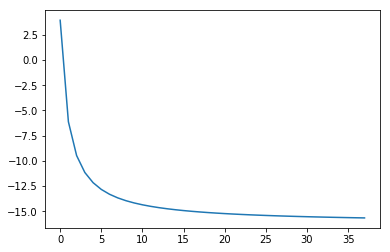

In [27]:
plt.plot(total_sum_array);

In [28]:
total_sum_array.reshape(-1,38).min(axis=1)

array([-15.65795162])

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

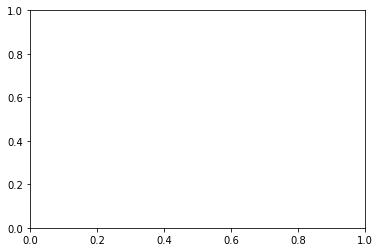

In [29]:
plt.plot([0.5, 0.75, 1.0, 2.0, 5.0, 10.0],total_sum_array.reshape(-1,38).min(axis=1));

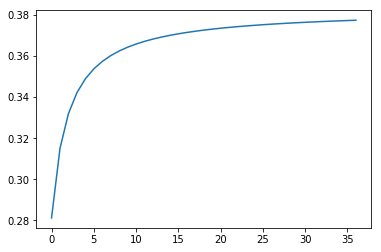

In [30]:
plt.plot(total_std_array[1:]);

In [31]:
total_std_array.reshape(-1,38).min(axis=1)

array([0.17984242])

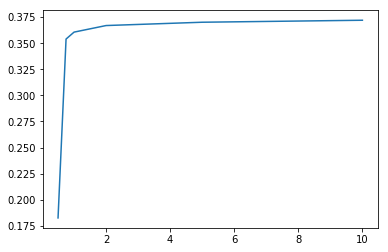

In [177]:
plt.plot([0.5, 0.75, 1.0, 2.0, 5.0, 10.0],total_std_array.reshape(-1,38).min(axis=1));

In [58]:
total_delta_pnl_array.reshape(100,-1).sum()

-25.69450348736716

In [59]:
total_delta_pnl_array.reshape(100,-1).std()

0.06737666083460346

In [19]:
config = Config(gpu_id=0)
config.tag = None

In [20]:
config_dict = {'data_type':'simulation',
               'hedging_task':'DeltaHedgingTiming-v0',
               'asset_model':'Heston',
               'strike_price':100,
               'option_type':'C',
               'lam':0.5,
               'nn_model':'lstm',
               'history_len':10,
               'burnin_len':5}

In [21]:
# config_dict.setdefault('log_level', 0)
# config_dict.setdefault('action_noise', 0)
# config.merge(config_dict)

# config.task_fn = lambda: Task(config.hedging_task, action_noise=config.action_noise, config=config)
# config.eval_env = config.task_fn()
# config.eval_interval = int(5e4)
# config.eval_episodes = 1000

# config.network_fn = lambda: TD3Net(
#     config.action_dim,b
#     actor_body_fn=lambda: FCBody(config.state_dim, (400, 300), gate=F.relu),
#     critic_body_fn=lambda: FCBody(
#         config.state_dim+config.action_dim, (400, 300), gate=F.relu),
#     actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
#     critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

# config.discount = 0.99
# config.td3_delay = 2
# config.warm_up = int(1e4)
# config.target_network_mix = 5e-3
# config.replay_fn = lambda: Replay(memory_size=int(5e4), batch_size=100)
# config.random_process_fn = lambda: GaussianProcess(
#     size=(config.action_dim,), std=LinearSchedule(0.1))
# config.td3_noise = 0.2
# config.td3_noise_clip = 0.5
# config.td3_delay = 2

In [22]:
config_dict.setdefault('log_level', 0)
config_dict.setdefault('action_noise', 0)
config.merge(config_dict)

config.task_fn = lambda: Task(config.hedging_task, action_noise=config.action_noise, config=config)
config.task = config.hedging_task.split('-')[0]
config.eval_env = config.task_fn()
config.eval_interval = int(5e4)
config.eval_episodes = 1000
config.lstm_encoding_size = 4
config.hidden_size = 32
config.actor_encoding_size = 3
config.critic_encoding_size = 4

config.network_fn = lambda: RTD3Net(
    config.state_dim,
    config.action_dim,
    config.actor_encoding_size,
    config.critic_encoding_size,
    actor_body_fn=lambda: OneDenseLSTM(config.state_dim+config.action_dim, config.lstm_encoding_size,
                                   config.hidden_size, config=config, gate=F.relu),
    critic_body_fn=lambda: OneDenseLSTM(
        config.state_dim+config.action_dim, config.lstm_encoding_size, config.hidden_size,
        config=config, gate=F.relu),
    actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
    critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
    config=config)


config.discount = 0.99
config.td3_delay = 2
config.warm_up = int(1e4)
config.target_network_mix = 5e-3
config.replay_fn = lambda: Replay(memory_size=int(5e4), batch_size=100)
config.random_process_fn = lambda: GaussianProcess(
    size=(config.action_dim,), std=LinearSchedule(0.1))
config.td3_noise = 0.2
config.td3_noise_clip = 0.5
config.td3_delay = 2

In [23]:
deltahedging_env = DeltaHedgingEnvTiming(config)

In [24]:
td3_agent = MVPITD3Agent(config)

In [50]:
reward_list = []
total_sum_array = np.zeros(0)
total_mean_array = np.zeros(0)
total_std_array = np.zeros(0)
total_delta_pnl_array = np.zeros(0)
for model_name in ['/codes/model/MVPITD3Agent-DeltaHedgingTiming-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_0.5-nn_model_lstm-option_type_C-strike_price_100.0-run-0-']:
    td3_agent = MVPITD3Agent(config)
    dir_name = os.getcwd()

    for model_index in range(1, 350000//9000 + 1):
        step_num = 9000 * model_index
        filename = dir_name + model_name + f'{step_num}' + '.model'

        state_dict = torch.load(filename)
        td3_agent.network.load_state_dict(state_dict)

        state_list = []
        action_array = np.array([])
        action_mean_array = np.array([])
        delta_array = np.array([])
        reward_array = np.array([])
        delta_pnl_array = np.array([])
        
        deltahedging_env = DeltaHedgingEnv(config, seed=0)
        
        for i in tqdm(range(100)):

            done = False
            state = deltahedging_env.reset()
            while not done:
                state = state.reshape(1,-1)
                action = td3_agent.eval_step(state, history=td3_agent.history)
                td3_agent.history.append(np.hstack([state, action]).flatten())
                delta = deltahedging_env.env_params.delta.copy()
                next_state, hedging_performance, done, _ = deltahedging_env.step(action, delta_check=True)
                if not done:
                    state_list.append(state)
                    action_array = np.append(action_array, action)
                    reward_array = np.append(reward_array, hedging_performance[0])
                    delta_pnl_array = np.append(delta_pnl_array, hedging_performance[1])
                    if len(hedging_performance) == 3:
                        intra_delta_pnl_array = np.append(intra_delta_pnl_array, hedging_performance[2])
                    delta_array = np.append(delta_array, delta)
                    state = next_state
                    
            td3_agent.history_reset(config)         
            reward_list.append([reward_array.sum(), reward_array.mean(), reward_array.std()])
            
        print(str(model_name) + '\n' + str(model_index))
        
        total_delta_pnl_array = np.append(total_delta_pnl_array, delta_pnl_array)
            
        total_sum_array = np.append(total_sum_array, np.array(reward_list)[:,0].mean())
        total_mean_array = np.append(total_mean_array, np.array(reward_list)[:,1].mean())
        total_std_array = np.append(total_std_array, np.array(reward_list)[:,2].mean())

  0%|          | 0/100 [00:00<?, ?it/s]

/codes/model/MVPITD3Agent-DeltaHedgingTiming-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_0.5-nn_model_lstm-option_type_C-strike_price_100.0-run-0-
1


 10%|█         | 10/100 [00:03<00:35,  2.54it/s]


KeyboardInterrupt: 

In [44]:
dir_name = os.getcwd()
model_index = 1


step_num = 9000 * model_index
filename = dir_name + '/codes/model/MVPITD3Agent-DeltaHedgingTiming-v0-asset_model_Heston-burnin_len_5-data_type_simulation-history_len_10-lam_0.5-nn_model_lstm-option_type_C-strike_price_100.0-run-0-'+ f'{step_num}' + '.model'

state_dict = torch.load(filename)
td3_agent.network.load_state_dict(state_dict)

<All keys matched successfully>

In [45]:
state_list = []
action_array = np.array([])
action_mean_array = np.array([])
delta_array = np.array([])
gamma_array = np.array([])
reward_array = np.array([])
delta_pnl_array = np.array([])
intra_delta_pnl_array = np.array([0])

done = False
state = deltahedging_env.reset()
while not done:
    state = state.reshape(1,-1)
    action =td3_agent.eval_step(state, history=td3_agent.history)
    action = np.round(action)
    td3_agent.history.append(np.hstack([state, action]).flatten())
    delta = deltahedging_env.env_params.delta.copy()
    gamma = get_gamma(state[0] * deltahedging_env.env_params.k, 
                  deltahedging_env.env_params.k, 
                  deltahedging_env.env_params.tau, 
                  deltahedging_env.env_params.ir,
                  state[-1])
    
    next_state, hedging_performance, done, _ = deltahedging_env.step(action, delta_check=True)
    if not done:
        state_list.append(state.reshape(1,-1))
        action_array = np.append(action_array, action)
        reward_array = np.append(reward_array, hedging_performance[0])
        delta_pnl_array = np.append(delta_pnl_array, hedging_performance[1])
        if len(hedging_performance) == 3:
            intra_delta_pnl_array = np.append(intra_delta_pnl_array, hedging_performance[2])
        delta_array = np.append(delta_array, delta)
        gamma_array = np.append(gamma_array, gamma)
        state = next_state
        
        
        
state_array = np.concatenate(state_list)

ValueError: x and y must have same first dimension, but have shapes (61,) and (1,)

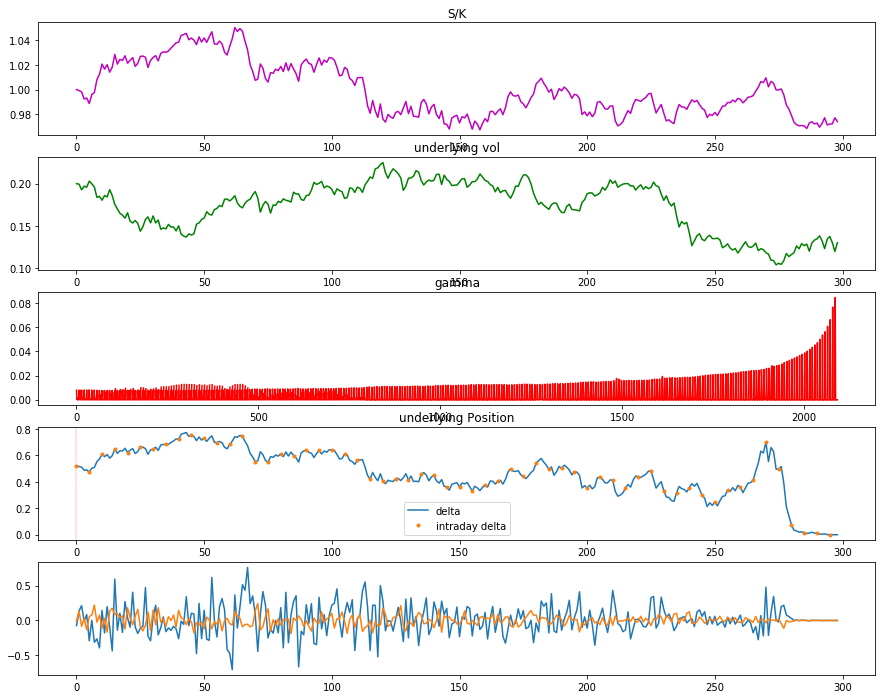

In [46]:
fig = plt.figure(figsize=(15,12))

plt.subplot(5,1,1)
plt.plot(state_array[:,0], 'm-')
plt.title('S/K')

plt.subplot(5,1,2)
plt.plot(state_array[:,-1], 'g-')
plt.title('underlying vol')

plt.subplot(5,1,3)
plt.plot(gamma_array, 'r-')
plt.title('gamma')

plt.subplot(5,1,4)
for ax in np.where(action_array==1)[0]:
    plt.axvline(x=ax, color='r', linestyle='--', linewidth=0.3)
plt.plot(delta_array, label='delta')
plt.plot(np.arange(0,300,5), delta_array[np.arange(0,300,5)], '.', label='intraday delta')
# plt.axvspan(np.where(state_array[:,-1]>0.2)[0][0], np.where(state_array[:,-1]<0.2)[0][0], facecolor='red', alpha=0.5)
# plt.axvspan(np.where(state_array[:,-1]<0.2)[0][0], np.where(state_array[:,-1]>0.2)[0][0], facecolor='blue', alpha=0.5)
plt.title('underlying Position')
plt.legend()

plt.subplot(5,1,5)
plt.plot(reward_array, label='RL')
plt.plot(delta_pnl_array, label='intraday_delta_hedging')
plt.plot(np.arange(0,301,5), intra_delta_pnl_array, label='daily_delta_hedging')
plt.title('hedging P&L')
plt.legend()

plt.tight_layout()

print(reward_array.sum(), reward_array.std())
print(delta_pnl_array.sum(), delta_pnl_array.std())
print(intra_delta_pnl_array.sum(), intra_delta_pnl_array.std())